
# Final project vizulations (Sunes work)



In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import folium
import urllib.request
import datetime
import plotly.express as px
from datetime import datetime, timedelta
from folium import plugins
from folium.plugins import HeatMap


In [227]:
months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
df_w = pd.read_csv("weather.csv") 
df_w['Year'] = pd.DatetimeIndex(df_w['date']).year
df_w['MonthNo'] = pd.DatetimeIndex(df_w['date']).month
df_w['Month'] = df_w['MonthNo'].apply(lambda x: months[x-1])
df_w['dayofyear'] = pd.DatetimeIndex(df_w['date']).dayofyear
df_w['date'] = pd.DatetimeIndex(df_w['date']).date
df_w


,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,Year,MonthNo,Month,dayofyear
0,2019-01-01,19.7,15.4,24.7,0.0,NaN,189.0,14.0,NaN,1012.3,NaN,2019,1,January,1
1,2019-01-02,19.2,16.1,22.7,0.0,NaN,171.0,17.5,NaN,1013.1,NaN,2019,1,January,2
2,2019-01-03,21.2,15.0,28.6,0.0,NaN,174.0,12.8,NaN,1011.1,NaN,2019,1,January,3
3,2019-01-04,26.5,19.1,37.4,0.0,NaN,323.0,22.8,NaN,1006.4,NaN,2019,1,January,4
4,2019-01-05,17.1,14.5,18.6,0.3,NaN,185.0,19.4,NaN,1013.3,NaN,2019,1,January,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,2022-03-31,15.2,12.6,18.3,0.0,NaN,153.0,19.1,NaN,1023.4,NaN,2022,3,March,90
1186,2022-04-01,14.7,11.7,18.3,0.0,NaN,141.0,19.8,NaN,1026.8,NaN,2022,4,April,91
1187,2022-04-02,15.2,12.4,17.6,0.0,NaN,148.0,16.8,NaN,1022.1,NaN,2022,4,April,92
1188,2022-04-03,15.7,13.9,17.4,1.1,NaN,164.0,11.7,NaN,1015.7,NaN,2022,4,April,93


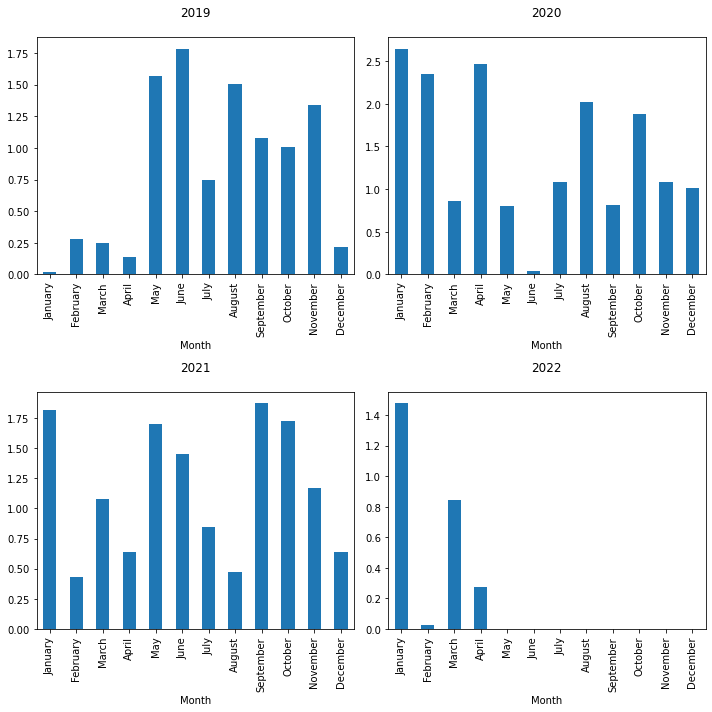

In [166]:
df_w['Month'] = pd.Categorical(df_w['Month'], categories=months, ordered=True)


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

df_w[(df_w.Year == 2019)].groupby(['Month']).mean()['prcp'].plot.bar(title='2019\n', ax=ax[0,0])

df_w[(df_w.Year == 2020)].groupby(['Month']).mean()['prcp'].plot.bar(title='2020\n', ax=ax[0,1])
df_w[(df_w.Year == 2021)].groupby(['Month']).mean()['prcp'].plot.bar(title='2021\n', ax=ax[1,0])
df_w[(df_w.Year == 2022)].groupby(['Month']).mean()['prcp'].plot.bar(title='2022\n', ax=ax[1,1])



plt.tight_layout() 
plt.show()

### Weekly patterns. Basically, we'll forget about the yearly variation and just count up what happens during each weekday. Here's what my version looks like. Make your own version of the plot and comment your results.

In [279]:
df_p = pd.read_csv("Pedestrian_Counting_System_-_Monthly__counts_per_hour_.csv") 
df_p['date'] = pd.DatetimeIndex(df_p['Date_Time']).date
df_p

,ID,Date_Time,Year,Month,Mdate,Day,Time,Sensor_ID,Sensor_Name,Hourly_Counts,date
0,2887628,"November 01, 2019 05:00:00 PM",2019,November,1,Friday,17,34,Flinders St-Spark La,300,2019-11-01
1,2887629,"November 01, 2019 05:00:00 PM",2019,November,1,Friday,17,39,Alfred Place,604,2019-11-01
2,2887630,"November 01, 2019 05:00:00 PM",2019,November,1,Friday,17,37,Lygon St (East),216,2019-11-01
3,2887631,"November 01, 2019 05:00:00 PM",2019,November,1,Friday,17,40,Lonsdale St-Spring St (West),627,2019-11-01
4,2887632,"November 01, 2019 05:00:00 PM",2019,November,1,Friday,17,36,Queen St (West),774,2019-11-01
...,...,...,...,...,...,...,...,...,...,...,...
4176213,4181685,"February 24, 2022 08:00:00 PM",2022,February,24,Thursday,20,86,Queensberry St - Errol St (South),69,2022-02-24
4176214,4181686,"February 24, 2022 09:00:00 PM",2022,February,24,Thursday,21,86,Queensberry St - Errol St (South),46,2022-02-24
4176215,4181687,"February 24, 2022 10:00:00 PM",2022,February,24,Thursday,22,86,Queensberry St - Errol St (South),52,2022-02-24
4176216,4181688,"February 24, 2022 11:00:00 PM",2022,February,24,Thursday,23,86,Queensberry St - Errol St (South),9,2022-02-24


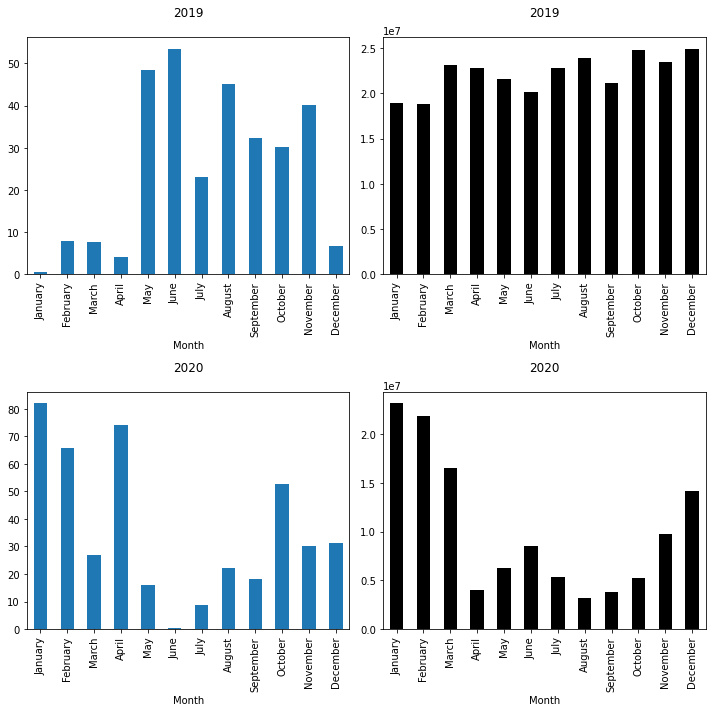

In [168]:

df_p['Month'] = pd.Categorical(df_p['Month'], categories=months, ordered=True)
df_w['Month'] = pd.Categorical(df_w['Month'], categories=months, ordered=True)


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

df_w[(df_w.Year == 2019)].groupby(['Month']).sum()['prcp'].plot.bar( title='2019\n', ax=ax[0,0])
df_p[(df_p.Year == 2019)].groupby(['Month']).sum()['Hourly_Counts'].plot.bar(color="black",title='2019\n', ax=ax[0,1])

df_w[(df_w.Year == 2020)].groupby(['Month']).sum()['prcp'].plot.bar(title='2020\n', ax=ax[1,0])
df_p[(df_p.Year == 2020)].groupby(['Month']).sum()['Hourly_Counts'].plot.bar(color="black",title='2020\n', ax=ax[1,1])




plt.tight_layout() 
plt.show()

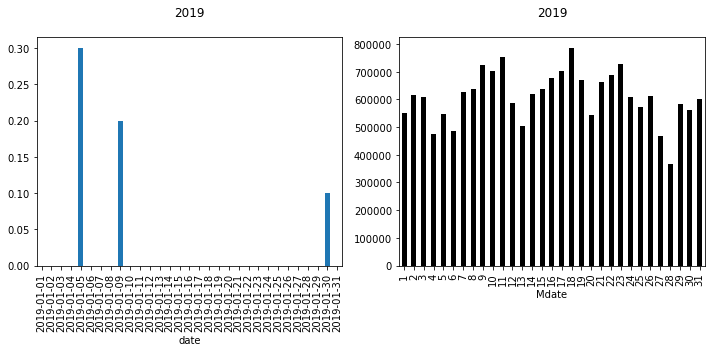

In [212]:




fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

df_w[(df_w.Year == 2019) & (df_w.Month == 'January')].groupby(['date']).sum()['prcp'].plot.bar( title='2019\n', ax=ax[0])
df_p[(df_p.Year == 2019) & (df_p.Month == 'January')].groupby(['Mdate']).sum()['Hourly_Counts'].plot.bar(color="black",title='2019\n', ax=ax[1])



plt.tight_layout() 
plt.show()

In [293]:
df_w['walker_counts'] = df_w['date'].apply(lambda date: df_pl[(df_pl.date == date)]['Hourly_Counts'].sum())
df_w


,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,Year,MonthNo,Month,dayofyear,walker_counts
0,2019-01-01,19.7,15.4,24.7,0.0,NaN,189.0,14.0,NaN,1012.3,NaN,2019,1,January,1,551774
1,2019-01-02,19.2,16.1,22.7,0.0,NaN,171.0,17.5,NaN,1013.1,NaN,2019,1,January,2,614728
2,2019-01-03,21.2,15.0,28.6,0.0,NaN,174.0,12.8,NaN,1011.1,NaN,2019,1,January,3,608655
3,2019-01-04,26.5,19.1,37.4,0.0,NaN,323.0,22.8,NaN,1006.4,NaN,2019,1,January,4,474641
4,2019-01-05,17.1,14.5,18.6,0.3,NaN,185.0,19.4,NaN,1013.3,NaN,2019,1,January,5,545995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,2022-03-31,15.2,12.6,18.3,0.0,NaN,153.0,19.1,NaN,1023.4,NaN,2022,3,March,90,0
1186,2022-04-01,14.7,11.7,18.3,0.0,NaN,141.0,19.8,NaN,1026.8,NaN,2022,4,April,91,0
1187,2022-04-02,15.2,12.4,17.6,0.0,NaN,148.0,16.8,NaN,1022.1,NaN,2022,4,April,92,0
1188,2022-04-03,15.7,13.9,17.4,1.1,NaN,164.0,11.7,NaN,1015.7,NaN,2022,4,April,93,0


In [471]:
def getRainData(year):
    xValues = []
    xLabels = []
    df_wf = df_w
    if (year != 0):
        df_wf = df_wf[(df_wf.Year == year)]
                      
    for n in range(0,12,2):
        xValues.append(df_wf[(df_wf.prcp > n-2) & (df_wf.prcp <= n)].walker_counts.mean())
        xLabels.append(f'{n-2} - {n}')
    xValues.append(df_wf[(df_wf.prcp > 10)].walker_counts.mean())
    xLabels[0] = '0'
    xLabels.append('> 10')
    return pd.Series(xValues, index = xLabels)



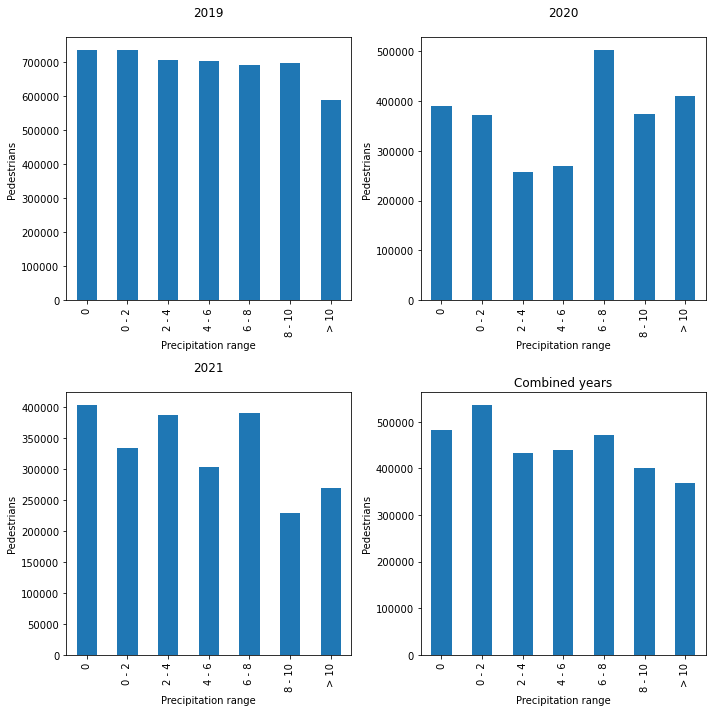

In [480]:

def getRow (num):
    return int(num/2)

def getCol (num):
    return int(num%2)



fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
yearsToPlot = [2019,2020,2021]

for n, yr in enumerate(yearsToPlot):
    getRainData(yr).plot.bar( title=f'{yr}\n', ax=ax[getRow(n),getCol(n)])
    ax[getRow(n),getCol(n)].set_ylabel('Pedestrians');
    ax[getRow(n),getCol(n)].set_xlabel('Precipitation range');


getRainData(0).plot.bar( title='Combined years', ax=ax[1,1])
ax[1,1].set_ylabel('Pedestrians');
ax[1,1].set_xlabel('Precipitation range');    

plt.tight_layout() 
plt.show()

<AxesSubplot:ylabel='Frequency'>

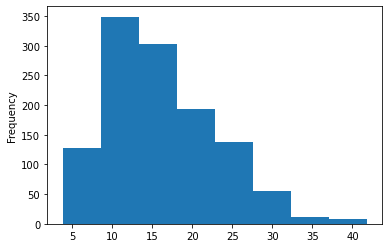

In [485]:
df_w['wspd'].plot.hist(bins=8)

In [525]:
def getWindData(year):
    xValues = []
    xLabels = []
    df_wf = df_w
    if (year != 0):
        df_wf = df_wf[(df_wf.Year == year)]
                      
    xValues.append(df_wf[(df_wf.prcp > 0) & (df_wf.wspd <= 10)].walker_counts.mean())
    xLabels.append('< 10')
    
    xValues.append(df_wf[(df_wf.prcp > 10) & (df_wf.wspd <= 15)].walker_counts.mean())
    xLabels.append('10 - 15')
    
    xValues.append(df_wf[(df_wf.prcp > 15) & (df_wf.wspd <= 20)].walker_counts.mean())
    xLabels.append('15 - 20')
    
    xValues.append(df_wf[(df_wf.prcp > 20) & (df_wf.wspd <= 25)].walker_counts.mean())
    xLabels.append('20 - 25')
        
    xValues.append(df_wf[(df_wf.prcp > 25)].walker_counts.mean())
    xLabels.append('> 25')
    
    return pd.Series(xValues, index = xLabels)

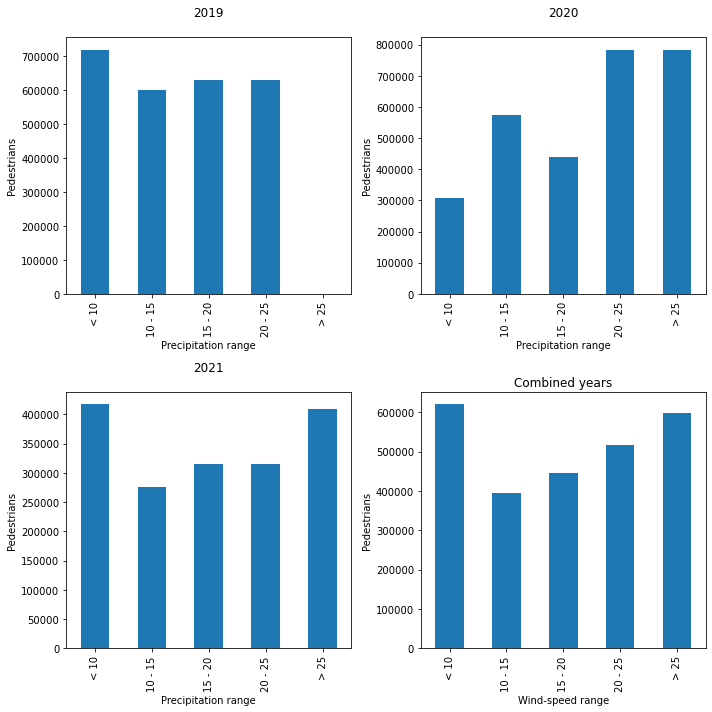

In [527]:
def getRow (num):
    return int(num/2)

def getCol (num):
    return int(num%2)



fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
yearsToPlot = [2019,2020,2021]

for n, yr in enumerate(yearsToPlot):
    getWindData(yr).plot.bar( title=f'{yr}\n', ax=ax[getRow(n),getCol(n)])
    ax[getRow(n),getCol(n)].set_ylabel('Pedestrians');
    ax[getRow(n),getCol(n)].set_xlabel('Precipitation range');


getWindData(0).plot.bar( title='Combined years', ax=ax[1,1])
ax[1,1].set_ylabel('Pedestrians');
ax[1,1].set_xlabel('Wind-speed range');    

plt.tight_layout() 
plt.show()